# Run FITS Generator Tool

In [69]:
# Make a prop file that can be used to run create_data (i.e. the FITS Generator Tool) on new warm aliveness images
# to transform the images from detector to DMS coordinates. After you have the prop file, just go to 
# the directory with your files, activate a jwst pipeline environment, and run:
# > create_data ./
#
# more info on create_data here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/fits_generator/description.html
#
# Once these files are in DMS coordinates, you can move them to the directory that stores all of the warm aliveness 
# images (/ifs/jwst/wit/witserv/data7/nrc/warm_aliveness_images/) and run the "Warm Aliveness Image Analysis" 
# cell below which will analyze this full collection of warm aliveness images.

import glob

# Put all of the files you are going to run through create_data into a single directory
files = glob.glob('./images_to_run_through_create_data/*.fits')

# Make the prop file
with open('./images_to_run_through_create_data/11111.prop', 'w') as prop_file:
    initial_info = """<Proposal title="WarmAlivenessTest">\n  <Observation>\n    <Visit>\n\
      <VisitGroup>\n        <ParallelSequenceID>\n          <Activity>\n"""
    prop_file.write(initial_info)
    for i,f in enumerate(files):
        prop_file.write('            <Exposure>\n              <Detector>\n                <base>{}</base>\n\
                <subarray></subarray>\n                <exp_type>NRC_DARK</exp_type>\
              \n              </Detector>\n            </Exposure>\n'.format(os.path.basename(f)))

    closing_info = """          </Activity>\n        </ParallelSequenceID>\n      </VisitGroup>\n\
    </Visit>\n  </Observation>\n </Proposal>\n"""
    prop_file.write(closing_info)


# Warm Aliveness Image Analysis

In [1]:
# Make a pdf flipbook with various plots that analyze the full collection of warm aliveness images

import glob
import os

from astropy.io import fits
from astropy.visualization import ZScaleInterval
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

######################################################### INPUTS #####################################################

# the detector to analyze; NRCB1, NRCALONG, etc.
detector = 'NRCA4'

# the frame to analyze; 1, 2 or 3 for single frame or 31, 21 or 32 for frame differences (where e.g. 31
# means frame 3 minus frame 1)
frame = '1'

# image scaling; either 'standardized' for all images to have the same scale, or 'optimized' for the scaling
# to be optimized for each individual image
image_scaling = 'standardized'

# options to manually set the histogram and collapsed row/column plot ranges for the images/difference images
# (set all to False to just use default ranges)
manual_collapsed_row_range = False
manual_row_min, manual_row_max = 17000,20000  # only relevant if manual_collapsed_row_range=True
manual_collapsed_column_range = False
manual_column_min, manual_column_max = 15000,19000  # only relevant if manual_collapsed_column_range=True
manual_hist_range = False
manual_hist_min, manual_hist_max = 12000,20000  # only relevant if manual_hist_range=True

manual_collapsed_row_range_diff = False
manual_row_min_diff, manual_row_max_diff = -20,20  # only relevant if manual_collapsed_row_range_diff=True
manual_collapsed_column_range_diff = False
manual_column_min_diff, manual_column_max_diff = -30,30  # only relevant if manual_collapsed_column_range_diff=True
manual_hist_range_diff = False
manual_hist_min_diff, manual_hist_max_diff = -500,500  # only relevant if manual_hist_range_diff=True

# option to set the flipbook title; leave blank to use the default (warm_aliveness_{detector}_frame{frame}.pdf)
fig_title = ''

######################################################################################################################

# The location of the warm aliveness images
IMAGE_DIR = '/ifs/jwst/wit/witserv/data7/nrc/warm_aliveness_images/'

# Make a file summarizing all of the warm aliveness images
print('Making a summary file of all of the warm aliveness images...')
df = pd.DataFrame({'file':[], 'expstart':[], 'detector':[], 'reset_voltage':[], 'asic_temp':[], 'fpa_temp':[]}, 
                  columns=['file','expstart','detector','reset_voltage','asic_temp','fpa_temp'])

# Add info for each warm aliveness image to the summary file
files = glob.glob(os.path.join(IMAGE_DIR, '*uncal.fits'))
for f in files:
    h = fits.open(f)
    dataset = os.path.basename(f)
    
    # Get the filename, exposure start time, and detector for this image
    entry = []
    entry.append(dataset)
    entry.append('{} {}'.format(h[0].header['DATE-OBS'], h[0].header['TIME-OBS']))
    entry.append(h[0].header['DETECTOR'])
    
    # Get the reset voltage for this image, if it exists
    try:
        entry.append(float(h[0].header['VRESET']))
    except KeyError:
        print('Warning: VRESET keyword not found for {}'.format(dataset))
        entry.append(np.nan)
    
    # Get the ASIC temperature for this image, if it exists
    try:
        entry.append(float(h[0].header['ASICTEMP']))
    except KeyError:
        print('Warning: ASICTEMP keyword not found for {}'.format(dataset))
        entry.append(np.nan)
    
    # Get the FPA temperature for this image
    if h[0].header['TMC1PWR'] == 'ON':
        entry.append(float(h[0].header['T_FPA1']))
    elif h[0].header['TMC2PWR'] == 'ON':
        entry.append(float(h[0].header['T_FPA2']))
    else:
        print('Neither TMC1PWR or TMC2PWR is ON for {}. Setting FPA temp to nan.'.format(f))
        entry.append(np.nan)
    
    # Add this image's info to the summary file
    df = df.append(pd.Series(entry, index=df.columns), ignore_index=True)
    h.close()

# Sort the summary file by exposure start time and write it out
df = df.sort_values(['expstart']).reset_index(drop=True)
df.to_csv('file_summary.txt', index=False)
print('Summary file complete.')

# Get the input info about which frame to analyze
if len(frame) == 2:
    f1, f2 = int(frame[0]) - 1, int(frame[1]) - 1  # subtract 1 because i.e. frame 1 is zero index
    frame_diff = True
elif len(frame) == 1:
    f1 = int(frame) - 1
    frame_diff = False
else:
    print('Frame={} not supported.'.format(frame))

# Get all of the dark info for the input detector
df_chosen = df[df['detector']==detector]
df_chosen = df_chosen.sort_values(['expstart']).reset_index(drop=True)
n = len(df_chosen)

# Make a reference stack of all of the 2017-2019 images
print('Making a reference image using 2017-2019 images...')
dtimes = pd.to_datetime(df_chosen['expstart'].values)
df_chosen_stack = df_chosen[(dtimes > '2017-01-01') & (dtimes < '2019-01-01')].reset_index(drop=True)
stack = np.zeros((len(df_chosen_stack), 2040, 2040))
for i in np.arange(len(df_chosen_stack)):
    chosen = df_chosen_stack.iloc[i]
    h = fits.open(os.path.join(IMAGE_DIR, chosen['file']), uint=False)
    if frame_diff == False:
        data = h[1].data[0][f1]
    else:
        data = h[1].data[0][f1] - h[1].data[0][f2]
    data = data[4:2044,4:2044]
    stack[i] = data
    h.close()
    
ref = np.nanmedian(stack, axis=0)
ref_collapsed_x = np.nanmedian(ref, axis=0)
ref_collapsed_y = np.nanmedian(ref, axis=1)
ref_med = np.nanmedian(ref)
print('Reference image created.')

# Find the scale limits/range to use for image gallery/histograms based on the reference image
r1, r2 = ref_med - 5*np.nanstd(ref), ref_med + 5*np.nanstd(ref)
if image_scaling == 'standardized':
    vmin, vmax = ref_med - 3*np.nanstd(ref), ref_med + 3*np.nanstd(ref)

# Initialize a flipbook and set up the figures/axes
if fig_title == '':
    fig_title = 'warm_aliveness_{}_frame{}.pdf'.format(detector, frame)
p = PdfPages(fig_title)
shape = n*4
size = shape*2
grid = plt.GridSpec(shape, shape, hspace=0.1, wspace=0.1)
fig = plt.figure(figsize=(size, size))
fig2 = plt.figure(figsize=(size, size))
fig3 = plt.figure(figsize=(size, size))
fig4 = plt.figure(figsize=(size, size))

# Plot the image/distribution/etc. for each image
print('Adding plots for each warm aliveness image to the flipbook...')
idx = 0  # controls the figure axis
idx_height = 0  # controls the figure height axis
for i in np.arange(n):
    
    # Get the data and other info for this image
    chosen = df_chosen.iloc[i]
    filename = chosen['file']
    h = fits.open(os.path.join(IMAGE_DIR, filename), uint=False)
    if frame_diff == False:
        data = h[1].data[0][f1]
    else:
        data = h[1].data[0][f1] - h[1].data[0][f2]
    data = data[4:2044,4:2044]
    h.close()
    
    #################### FIGURE 1 (images) ####################
    main_ax = fig.add_subplot(grid[idx_height:idx_height+4, idx+1:idx+3])
    y_ax = fig.add_subplot(grid[idx_height+1:idx_height+3, idx])
    x_ax = fig.add_subplot(grid[idx_height, idx+1:idx+3])
    
    if image_scaling == 'optimized':
        interval = ZScaleInterval()
        vmin, vmax = interval.get_limits(data)
    
    main_ax.imshow(data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    main_ax.set_xlim(0, data.shape[0])
    main_ax.set_ylim(0, data.shape[0])
    main_ax.set_xticks([])
    main_ax.set_yticks([])

    rowcol = np.arange(0, data.shape[0])
    vals  = np.nanmedian(data, axis=0)
    x_ax.scatter(rowcol, vals, s=1, color='steelblue', alpha=0.5)
    x_ax.scatter(rowcol, ref_collapsed_x, s=1, color='coral', alpha=0.5)
    x_ax.set_xticks([])
    x_ax.set_xlim(0, data.shape[0])
    x_ax.set_title('{} \n {} \n Median: {:.3f}  FPA temp: {:.3f} \n Image Scale: {:.0f} to {:.0f}'\
                   .format(filename, chosen['expstart'], np.nanmedian(data), chosen['fpa_temp'], vmin, vmax))
    if manual_collapsed_column_range == True:
        x_ax.set_ylim(manual_column_min, manual_column_max)

    vals  = np.nanmedian(data, axis=1)
    y_ax.scatter(vals, rowcol, s=1, color='steelblue', alpha=0.5)
    y_ax.scatter(ref_collapsed_y, rowcol, s=1, color='coral', alpha=0.5)
    y_ax.set_yticks([])
    y_ax.set_ylim(0, data.shape[0])
    if manual_collapsed_row_range == True:
        y_ax.set_xlim(manual_row_min, manual_row_max)
    y_ax.invert_xaxis()
    
    #################### FIGURE 2 (image histograms) ####################
    if manual_hist_range == True:
        r1, r2 = manual_hist_min, manual_hist_max
    n1, n2 = len(data[data<r1]), len(data[data>r2])
    main_ax = fig2.add_subplot(grid[idx_height:idx_height+3, idx+1:idx+4])
    main_ax.hist(data.flatten(), bins=50, range=(r1, r2), color='steelblue', alpha=0.5)
    main_ax.hist(ref.flatten(), bins=50, range=(r1, r2), color='coral', alpha=0.5)
    main_ax.set_xlim(r1,r2)
    main_ax.set_yscale('log')
    main_ax.set_ylim(1,1e7)
    main_ax.set_title('{} \n {} \n Median: {:.3f}  FPA temp: {:.3f} \n N<{:.0f}: {}  N>{:.0f}: {}'\
                      .format(filename, chosen['expstart'], np.nanmedian(data), chosen['fpa_temp'], r1, n1, r2, n2))

    #################### FIGURE 3 (difference images) ####################
    diff = (data - np.nanmedian(data)) - (ref - ref_med)
    if (i == 0) & (image_scaling == 'standardized'):
        good_diff = diff[np.isfinite(diff)]
        diff_vmin = np.nanmedian(good_diff) - 3*np.nanstd(good_diff)
        diff_vmax = np.nanmedian(good_diff) + 3*np.nanstd(good_diff)
    main_ax = fig3.add_subplot(grid[idx_height:idx_height+4, idx+1:idx+3])
    y_ax = fig3.add_subplot(grid[idx_height+1:idx_height+3, idx])
    x_ax = fig3.add_subplot(grid[idx_height, idx+1:idx+3])
    
    if image_scaling == 'optimized':
        interval = ZScaleInterval()
        diff_vmin, diff_vmax = interval.get_limits(diff)
    
    main_ax.imshow(diff, cmap='gray', origin='lower', vmin=diff_vmin, vmax=diff_vmax)
    main_ax.set_xlim(0, data.shape[0])
    main_ax.set_ylim(0, data.shape[0])
    main_ax.set_xticks([])
    main_ax.set_yticks([])

    rowcol = np.arange(0, data.shape[0])
    vals  = np.nanmedian(diff, axis=0)
    sorted_vals = np.sort(vals)
    x_ax.scatter(rowcol, vals, s=1, color='steelblue', alpha=0.5)
    x_ax.set_xticks([])
    x_ax.set_xlim(0, data.shape[0])
    x_ax.set_title('{} \n {} \n Median: {:.3f}  FPA temp: {:.3f} \n Image Scale: {:.0f} to {:.0f}'\
                   .format(filename, chosen['expstart'], np.nanmedian(diff), chosen['fpa_temp'], diff_vmin, diff_vmax))
    if manual_collapsed_column_range_diff == True:
        x_ax.set_ylim(manual_column_min_diff, manual_column_max_diff)
    else:
        x_ax.set_ylim(sorted_vals[int(len(vals)*0.02)], sorted_vals[int(len(vals)*0.98)])  # reject outliers in limits
    
    vals  = np.nanmedian(diff, axis=1)
    sorted_vals = np.sort(vals)
    y_ax.scatter(vals, rowcol, s=1, color='steelblue', alpha=0.5)
    y_ax.set_xlim(sorted_vals[int(len(vals)*0.02)], sorted_vals[int(len(vals)*0.98)])  # reject outliers in limits
    y_ax.set_yticks([])
    y_ax.set_ylim(0, data.shape[0])
    if manual_collapsed_row_range_diff == True:
        y_ax.set_xlim(manual_row_min_diff, manual_row_max_diff)
    y_ax.invert_xaxis()
    
    #################### FIGURE 4 (difference image histograms) ####################
    if manual_hist_range_diff == True:
        diff_r1, diff_r2 = manual_hist_min_diff, manual_hist_max_diff
    else:
        if i == 0:
            diff_r1 = np.nanmedian(good_diff) - 5*np.nanstd(good_diff)
            diff_r2 = np.nanmedian(good_diff) + 5*np.nanstd(good_diff)
    n1, n2 = len(diff[diff<diff_r1]), len(diff[diff>diff_r2])
    main_ax = fig4.add_subplot(grid[idx_height:idx_height+3, idx+1:idx+4])
    main_ax.hist(diff.flatten(), bins=50, range=(diff_r1, diff_r2))
    main_ax.set_yscale('log')
    main_ax.set_ylim(1,1e7)
    main_ax.set_xlim(diff_r1, diff_r2)
    main_ax.set_title('{} \n {} \n Median: {:.3f}  FPA temp: {:.3f} \n N<{:.0f}: {}  N>{:.0f}: {}'\
                      .format(filename, chosen['expstart'], np.nanmedian(diff), chosen['fpa_temp'], 
                              diff_r1, n1, diff_r2, n2))
    
    ###########################################################################
    
    # Go to the next image in the grid
    idx+=4
    if idx%16==0:
        idx_height += 4
        idx = 0
    
    # Progess tracker
    print('{}/{} images complete'.format(i+1, n))

# Save/close the figures
print('Saving the flipbook...')
p.savefig(fig, bbox_inches='tight', dpi=50)
p.savefig(fig2, bbox_inches='tight', dpi=50)
p.savefig(fig3, bbox_inches='tight', dpi=50)
p.savefig(fig4, bbox_inches='tight', dpi=50)

fig.savefig('a4_1.png',bbox_inches='tight',dpi=50)
fig2.savefig('a4_2.png',bbox_inches='tight',dpi=50)
fig3.savefig('a4_3.png',bbox_inches='tight',dpi=50)
fig4.savefig('a4_4.png',bbox_inches='tight',dpi=50)

fig.clf()
fig2.clf()
fig3.clf()
fig4.clf()
p.close()
print('Flipbook saved.')
print('Warm aliveness analysis complete.')


Making a summary file of all of the warm aliveness images...
Summary file complete.
Making a reference image using 2017-2019 images...
Reference image created.
Adding plots for each warm aliveness image to the flipbook...
1/18 images complete
2/18 images complete
3/18 images complete
4/18 images complete
5/18 images complete
6/18 images complete
7/18 images complete
8/18 images complete
9/18 images complete
10/18 images complete
11/18 images complete
12/18 images complete
13/18 images complete
14/18 images complete
15/18 images complete
16/18 images complete
17/18 images complete
18/18 images complete
Saving the flipbook...
Flipbook saved.
Warm aliveness analysis complete.


# Other Useful Scripts

In [1]:
import glob
import os

from astropy.io import fits
from astropy.visualization import ZScaleInterval
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [ ]:
# Simplified warm aliveness analysis script
# Just plot time-sorted gallery of warm aliveness images (i.e. page 1 of the flipbook)

import glob
import os

from astropy.io import fits
from astropy.visualization import ZScaleInterval
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

######################################################### INPUTS #####################################################

# the detector to analyze; NRCB1, NRCALONG, etc.
detector = 'NRCBLONG'

# the frame to analyze; 1, 2 or 3 for single frame or 31, 21 or 32 for frame differences (where e.g. 31
# means frame 3 minus frame 1)
frame = '1'

# image scaling; either 'standardized' for all images to have the same scale, 'optimized' for the scaling
# to be optimized for each individual image, or 'manual' to use a manually set vmin/vmax for all images
image_scaling = 'manual'
manual_vmin, manual_vmax = 20000,45000  # only relevant if image_scaling='manual'

# options to manually set the collapsed row/column plot ranges for the images (set all to False to just 
# use default ranges)
manual_collapsed_row_range = False
manual_row_min, manual_row_max = 17000,20000  # only relevant if manual_collapsed_row_range=True
manual_collapsed_column_range = False
manual_column_min, manual_column_max = 15000,19000  # only relevant if manual_collapsed_column_range=True

# option to set the flipbook title; leave blank to use the default (warm_aliveness_{detector}_frame{frame}.png)
fig_title = ''

# option to make summary file; can set to false if re-running e.g. multiple detectors since it was already
# made during the first run
make_summary = True

# option to make reference image; can set to false if re-running e.g. multiple detectors since it was already
# made during the first run
make_refimage = True

# the minimum date YYYY-MM-DD of the warm aliveness images to analyze (i.e. images before this date 
# won't be plotted/used)
min_dtime = '2017-01-01'

######################################################################################################################

# The location of the warm aliveness images
IMAGE_DIR = '/ifs/jwst/wit/witserv/data7/nrc/warm_aliveness_images/'

# Make a file summarizing all of the warm aliveness images
print('Making a summary file of all of the warm aliveness images...')
df = pd.DataFrame({'file':[], 'expstart':[], 'detector':[], 'reset_voltage':[], 'asic_temp':[], 'fpa_temp':[]}, 
                  columns=['file','expstart','detector','reset_voltage','asic_temp','fpa_temp'])

# Add info for each warm aliveness image to the summary file
files = glob.glob(os.path.join(IMAGE_DIR, '*uncal.fits'))
if make_summary:
    for f in files:
        h = fits.open(f)
        dataset = os.path.basename(f)

        # Get the filename, exposure start time, and detector for this image
        entry = []
        entry.append(dataset)
        entry.append('{} {}'.format(h[0].header['DATE-OBS'], h[0].header['TIME-OBS']))
        entry.append(h[0].header['DETECTOR'])

        # Get the reset voltage for this image, if it exists
        try:
            entry.append(float(h[0].header['VRESET']))
        except KeyError:
            print('Warning: VRESET keyword not found for {}'.format(dataset))
            entry.append(np.nan)

        # Get the ASIC temperature for this image, if it exists
        try:
            entry.append(float(h[0].header['ASICTEMP']))
        except KeyError:
            print('Warning: ASICTEMP keyword not found for {}'.format(dataset))
            entry.append(np.nan)

        # Get the FPA temperature for this image
        try:
            if h[0].header['TMC1PWR'] == 'ON':
                entry.append(float(h[0].header['T_FPA1']))
            elif h[0].header['TMC2PWR'] == 'ON':
                entry.append(float(h[0].header['T_FPA2']))
            else:
                print('Neither TMC1PWR or TMC2PWR is ON for {}. Setting FPA temp to nan.'.format(f))
                entry.append(np.nan)
        except KeyError:
            entry.append(np.nan)

        # Add this image's info to the summary file
        df = df.append(pd.Series(entry, index=df.columns), ignore_index=True)
        h.close()

    # Sort the summary file by exposure start time and write it out
    df = df.sort_values(['expstart']).reset_index(drop=True)
    df.to_csv('file_summary.txt', index=False)
    print('Summary file complete.')
df = pd.read_csv('file_summary.txt')

# Get the input info about which frame to analyze
if len(frame) == 2:
    f1, f2 = int(frame[0]) - 1, int(frame[1]) - 1  # subtract 1 because i.e. frame 1 is zero index
    frame_diff = True
elif len(frame) == 1:
    f1 = int(frame) - 1
    frame_diff = False
else:
    print('Frame={} not supported.'.format(frame))

# Get all of the dark info for the input detector/date range
df_chosen = df[df['detector']==detector]
dtimes = pd.to_datetime(df_chosen['expstart'].values)
df_chosen = df_chosen[(dtimes > min_dtime)]
df_chosen = df_chosen.sort_values(['expstart']).reset_index(drop=True)
n = len(df_chosen)

# Make a reference stack of all of the 2017-2019 images
if make_refimage:
    print('Making a reference image using 2017-2019 images...')
    dtimes = pd.to_datetime(df_chosen['expstart'].values)
    df_chosen_stack = df_chosen[(dtimes > '2017-01-01') & (dtimes < '2019-01-01')].reset_index(drop=True)
    stack = np.zeros((len(df_chosen_stack), 2040, 2040))
    for i in np.arange(len(df_chosen_stack)):
        chosen = df_chosen_stack.iloc[i]
        h = fits.open(os.path.join(IMAGE_DIR, chosen['file']), uint=False)
        if frame_diff == False:
            data = h[1].data[0][f1]
        else:
            data = h[1].data[0][f1] - h[1].data[0][f2]
        data = data[4:2044,4:2044]
        stack[i] = data
        h.close()

    ref = np.nanmedian(stack, axis=0)
    ref_collapsed_x = np.nanmedian(ref, axis=0)
    ref_collapsed_y = np.nanmedian(ref, axis=1)
    ref_med = np.nanmedian(ref)
    print('Reference image created.')

# Find the scale limits/range to use for image gallery
r1, r2 = ref_med - 5*np.nanstd(ref), ref_med + 5*np.nanstd(ref)
if image_scaling == 'standardized':
    vmin, vmax = ref_med - 3*np.nanstd(ref), ref_med + 3*np.nanstd(ref)
if image_scaling == 'manual':
    vmin, vmax = manual_vmin, manual_vmax

# Initialize a flipbook and set up the figures/axes
if fig_title == '':
    fig_title = 'warm_aliveness_{}_frame{}.png'.format(detector, frame)
shape = n*4
size = shape*2
grid = plt.GridSpec(shape, shape, hspace=0.1, wspace=0.1)
fig = plt.figure(figsize=(size, size))

# Plot the image/distribution/etc. for each image
print('Adding plots for each warm aliveness image to the flipbook...')
idx = 0  # controls the figure axis
idx_height = 0  # controls the figure height axis
for i in np.arange(n):
    
    # Get the data and other info for this image
    chosen = df_chosen.iloc[i]
    filename = chosen['file']
    h = fits.open(os.path.join(IMAGE_DIR, filename), uint=False)
    try:
        oldfile = h[0].header['OLDFILE']
        filename_title = oldfile
    except KeyError:
        filename_title = filename
    if frame_diff == False:
        data = h[1].data[0][f1]
    else:
        data = h[1].data[0][f1] - h[1].data[0][f2]
    data = data[4:2044,4:2044]
    h.close()
    
    #################### FIGURE 1 (images) ####################
    main_ax = fig.add_subplot(grid[idx_height:idx_height+4, idx+1:idx+3])
    y_ax = fig.add_subplot(grid[idx_height+1:idx_height+3, idx])
    x_ax = fig.add_subplot(grid[idx_height, idx+1:idx+3])
    
    if image_scaling == 'optimized':
        interval = ZScaleInterval()
        vmin, vmax = interval.get_limits(data)
    
    main_ax.imshow(data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    main_ax.set_xlim(0, data.shape[0])
    main_ax.set_ylim(0, data.shape[0])
    main_ax.set_xticks([])
    main_ax.set_yticks([])

    rowcol = np.arange(0, data.shape[0])
    vals  = np.nanmedian(data, axis=0)
    x_ax.scatter(rowcol, vals, s=1, color='steelblue', alpha=0.5)
    x_ax.scatter(rowcol, ref_collapsed_x, s=1, color='coral', alpha=0.5)
    x_ax.set_xticks([])
    x_ax.set_xlim(0, data.shape[0])
    x_ax.set_title('{} \n {} \n Median: {:.3f}  FPA temp: {:.3f} \n Image Scale: {:.0f} to {:.0f}'\
                   .format(filename_title, chosen['expstart'], np.nanmedian(data), chosen['fpa_temp'], vmin, vmax))
    if manual_collapsed_column_range == True:
        x_ax.set_ylim(manual_column_min, manual_column_max)

    vals  = np.nanmedian(data, axis=1)
    y_ax.scatter(vals, rowcol, s=1, color='steelblue', alpha=0.5)
    y_ax.scatter(ref_collapsed_y, rowcol, s=1, color='coral', alpha=0.5)
    y_ax.set_yticks([])
    y_ax.set_ylim(0, data.shape[0])
    if manual_collapsed_row_range == True:
        y_ax.set_xlim(manual_row_min, manual_row_max)
    y_ax.invert_xaxis()
    
    # Go to the next image in the grid
    idx+=4
    if idx%16==0:
        idx_height += 4
        idx = 0
    
    # Progess tracker
    print('{}/{} images complete'.format(i+1, n))

# Save/close the figures
print('Saving the image gallery...')
fig.savefig(fig_title, bbox_inches='tight', dpi=75)
fig.clf()
print('Image gallery saved.')
print('Warm aliveness analysis complete.')


Making a reference image using 2017-2019 images...
Reference image created.


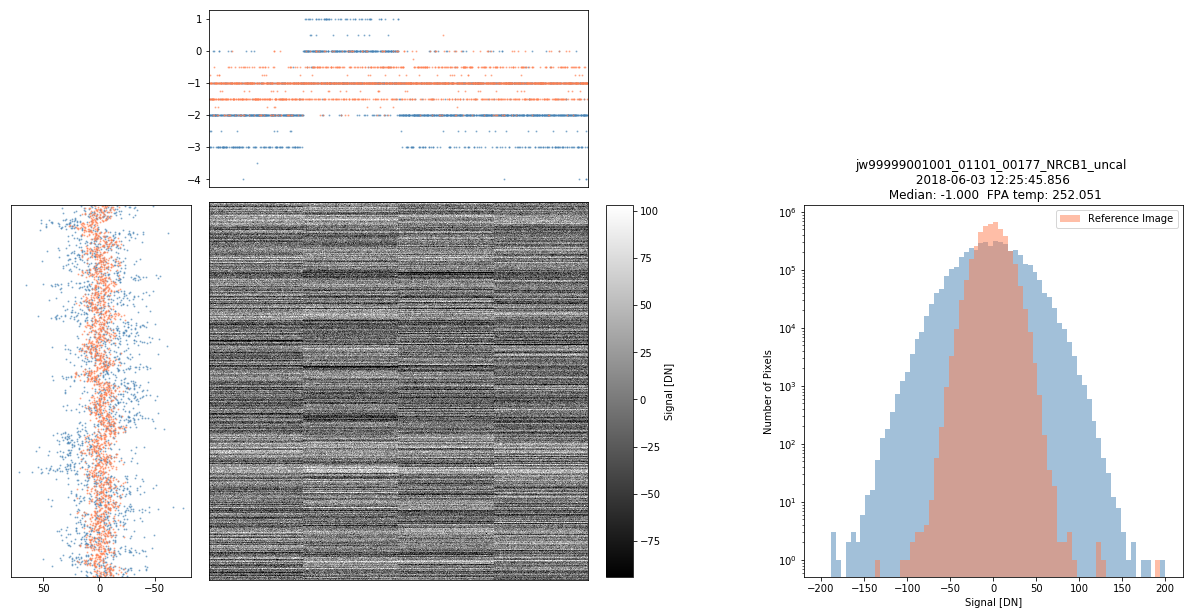

In [11]:
# Plot a single image, including the collapsed row/column values and a histogram of the values
# (i.e. the plots on pages 1 and 2 of the flipbook for a single image)

######################################################### INPUTS ####################################################

# the image to plot
filename = '/ifs/jwst/wit/witserv/data7/nrc/warm_aliveness_images/jw99999001001_01101_00177_NRCB1_uncal.fits'

# the frame to analyze; 1, 2 or 3 for single frame or 31, 21 or 32 for frame differences (where e.g. 31
# means frame 3 minus frame 1)
frame = '21'

# option to overplot the reference image
overplot_ref = True

# option to save the figure and set the figure title
save = True
fig_title = ''  # leave blank to use default (dataset_frame{frame}.png)

# option to manually set the histogram and collapsed row/column ranges
manual_hist_range = True
manual_hist_min, manual_hist_max = -200,200  # only relevant if manual_hist_range=True
manual_collapsed_row_range = False
manual_row_min, manual_row_max = 15000,20000  # only relevant if manual_collapsed_row_range=True
manual_collapsed_column_range = False
manual_column_min, manual_column_max = 10000,20000  # only relevant if manual_collapsed_column_range=True

#####################################################################################################################

# Get the input info about which frame to analyze
if len(frame) == 2:
    f1, f2 = int(frame[0]) - 1, int(frame[1]) - 1  # subtract 1 because i.e. frame 1 is zero index
    frame_diff = True
elif len(frame) == 1:
    f1 = int(frame) - 1
    frame_diff = False
else:
    print('Frame={} not supported.'.format(frame))

# Get file data and other info
dataset = os.path.basename(filename).replace('.fits','')
h = fits.open(filename, uint=False)
if frame_diff == False:
    data = h[1].data[0][f1]
else:
    data = h[1].data[0][f1] - h[1].data[0][f2]
data = data[4:2044,4:2044]
expstart = '{} {}'.format(h[0].header['DATE-OBS'], h[0].header['TIME-OBS'])
detector = h[0].header['DETECTOR']
if h[0].header['TMC1PWR'] == 'ON':
    fpa = float(h[0].header['T_FPA1'])
elif h[0].header['TMC2PWR'] == 'ON':
    fpa = float(h[0].header['T_FPA2'])
    
# Find the image scale
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data)

# Set up the grid
grid = plt.GridSpec(4, 6, hspace=0.1, wspace=0.1)
fig = plt.figure(figsize=(21, 14))
main_ax = fig.add_subplot(grid[0:4, 1:3])
y_ax = fig.add_subplot(grid[1:3, 0])
x_ax = fig.add_subplot(grid[0, 1:3])
cbar_ax = fig.add_subplot(grid[1:3, 3:4])
hist_ax = fig.add_subplot(grid[1:3,4:6])

# Set up the main axes and display the image
c = main_ax.imshow(data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
main_ax.set_xlim(0, data.shape[0])
main_ax.set_ylim(0, data.shape[0])
main_ax.set_xticks([])
main_ax.set_yticks([])

# Make the colorbar
box = cbar_ax.get_position()
cbar_ax.set_position([box.x0, box.y0, box.width * .15 , box.height * 1])
fig.colorbar(c, cax=cbar_ax)
cbar_ax.set_ylabel('Signal [DN]')

# Display the collapsed row/column values of the image
rowcol = np.arange(0, data.shape[0])
vals  = np.nanmedian(data, axis=0)
x_ax.scatter(rowcol, vals, s=1, color='steelblue', alpha=0.5)
x_ax.set_xticks([])
x_ax.set_xlim(0, data.shape[0])
# x_ax.set_title('{} \n {} \n Median: {:.3f}  FPA temp: {:.3f} \n Image Scale: {:.0f} to {:.0f}'\
#                .format(dataset, expstart, np.nanmedian(data), fpa, vmin, vmax))
if manual_collapsed_column_range == True:
    x_ax.set_ylim(manual_column_min, manual_column_max)

vals  = np.nanmedian(data, axis=1)
y_ax.scatter(vals, rowcol, s=1, color='steelblue', alpha=0.5)
y_ax.set_yticks([])
y_ax.set_ylim(0, data.shape[0])
if manual_collapsed_row_range == True:
    y_ax.set_xlim(manual_row_min, manual_row_max)
y_ax.invert_xaxis()

# Display the historgram
if manual_hist_range == True:
    hist_ax.hist(data.flatten(), bins=70, color='steelblue', alpha=0.5, range=(manual_hist_min, manual_hist_max))
else:
    hist_ax.hist(data.flatten(), bins=70, color='steelblue', alpha=0.5)
hist_ax.set_yscale('log')
hist_ax.set_ylabel('Number of Pixels')
hist_ax.set_xlabel('Signal [DN]')
hist_ax.set_title('{} \n {} \n Median: {:.3f}  FPA temp: {:.3f}'\
                  .format(dataset, expstart, np.nanmedian(data), fpa, vmin, vmax))
h.close()

# Overplot the reference image, and create it/the summary dataframe if needed
if overplot_ref == True:
    
    # The location of the warm aliveness images
    IMAGE_DIR = '/ifs/jwst/wit/witserv/data7/nrc/warm_aliveness_images/'

    # Make a file summarizing all of the warm aliveness images, unless it already exists
    if not os.path.isfile('file_summary.txt'):
        print('Making a summary file of all of the warm aliveness images...')
        df = pd.DataFrame({'file':[], 'expstart':[], 'detector':[], 'reset_voltage':[], 'asic_temp':[], 'fpa_temp':[]}, 
                          columns=['file','expstart','detector','reset_voltage','asic_temp','fpa_temp'])

        # Add info for each warm aliveness image to the summary file
        files = glob.glob(os.path.join(IMAGE_DIR, '*uncal.fits'))
        for f in files:
            h = fits.open(f)
            dataset = os.path.basename(f)

            # Get the filename, exposure start time, and detector for this image
            entry = []
            entry.append(dataset)
            entry.append('{} {}'.format(h[0].header['DATE-OBS'], h[0].header['TIME-OBS']))
            entry.append(h[0].header['DETECTOR'])

            # Get the reset voltage for this image, if it exists
            try:
                entry.append(float(h[0].header['VRESET']))
            except KeyError:
                print('Warning: VRESET keyword not found for {}'.format(dataset))
                entry.append(np.nan)

            # Get the ASIC temperature for this image, if it exists
            try:
                entry.append(float(h[0].header['ASICTEMP']))
            except KeyError:
                print('Warning: ASICTEMP keyword not found for {}'.format(dataset))
                entry.append(np.nan)

            # Get the FPA temperature for this image
            if h[0].header['TMC1PWR'] == 'ON':
                entry.append(float(h[0].header['T_FPA1']))
            elif h[0].header['TMC2PWR'] == 'ON':
                entry.append(float(h[0].header['T_FPA2']))
            else:
                print('Neither TMC1PWR or TMC2PWR is ON for {}. Setting FPA temp to nan.'.format(f))
                entry.append(np.nan)

            # Add this image's info to the summary file
            df = df.append(pd.Series(entry, index=df.columns), ignore_index=True)
            h.close()

        # Sort the summary file by exposure start time and write it out
        df = df.sort_values(['expstart']).reset_index(drop=True)
        print('Summary file complete.')
    else:
        df = pd.read_csv('file_summary.txt')

    # Get all of the dark info for the input detector
    df_chosen = df[df['detector']==detector]
    df_chosen = df_chosen.sort_values(['expstart']).reset_index(drop=True)
    n = len(df_chosen)

    # Make a reference stack of all of the 2017-2019 images
    print('Making a reference image using 2017-2019 images...')
    dtimes = pd.to_datetime(df_chosen['expstart'].values)
    df_chosen_stack = df_chosen[(dtimes > '2017-01-01') & (dtimes < '2019-01-01')].reset_index(drop=True)
    stack = np.zeros((len(df_chosen_stack), 2040, 2040))
    for i in np.arange(len(df_chosen_stack)):
        chosen = df_chosen_stack.iloc[i]
        h = fits.open(os.path.join(IMAGE_DIR, chosen['file']), uint=False)
        if frame_diff == False:
            data = h[1].data[0][f1]
        else:
            data = h[1].data[0][f1] - h[1].data[0][f2]
        data = data[4:2044,4:2044]
        stack[i] = data
        h.close()

    ref = np.nanmedian(stack, axis=0)
    ref_collapsed_x = np.nanmedian(ref, axis=0)
    ref_collapsed_y = np.nanmedian(ref, axis=1)
    ref_med = np.nanmedian(ref)
    print('Reference image created.')
    
    # Overplot the reference image data
    rowcol = np.arange(0, ref.shape[0])
    vals  = np.nanmedian(ref, axis=0)
    x_ax.scatter(rowcol, vals, s=1, color='coral', alpha=0.5)
    vals  = np.nanmedian(ref, axis=1)
    y_ax.scatter(vals, rowcol, s=1, color='coral', alpha=0.5)
    if manual_hist_range == True:
        hist_ax.hist(ref.flatten(), bins=70, color='coral', alpha=0.5, label='Reference Image', 
                     range=(manual_hist_min, manual_hist_max))
    else:
        hist_ax.hist(ref.flatten(), bins=70, color='coral', alpha=0.5, label='Reference Image')
    hist_ax.legend()

if save == True:
    if fig_title == '':
        fig_title = '{}_frame{}'.format(dataset, frame)
    fig.savefig('{}.png'.format(fig_title), bbox_inches='tight', dpi=200)


Making a reference image using 2017-2019 images...
Reference image created.


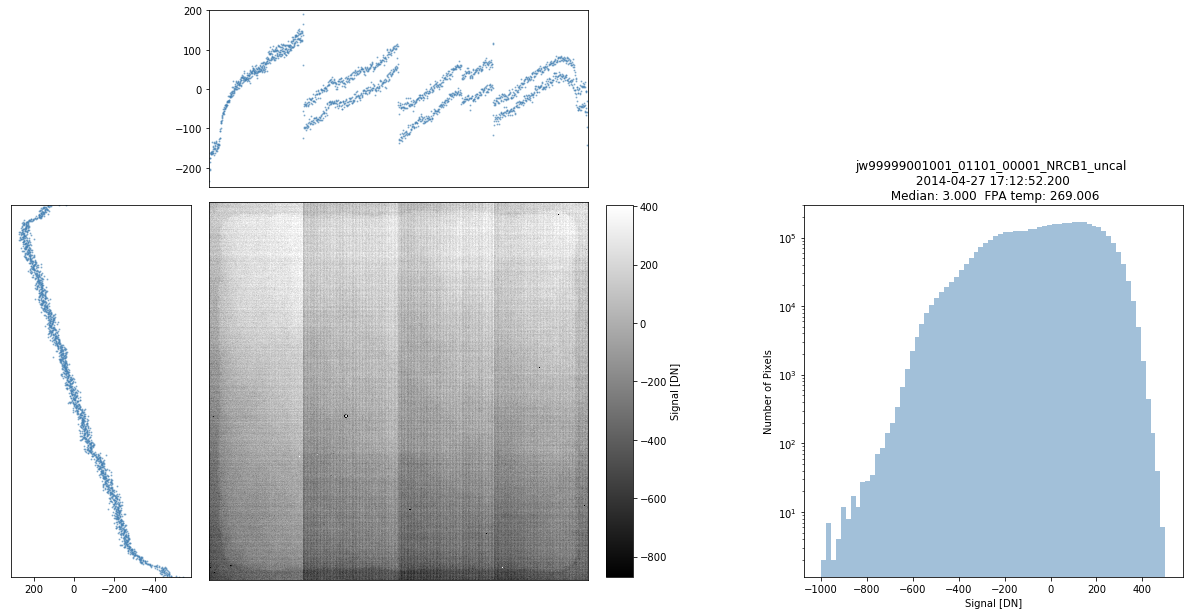

In [3]:
# Plot a single difference image, including the collapsed row/column values and a histogram of the values
# (i.e. the plots on pages 3 and 4 of the flipbook for a single image)

######################################################### INPUTS ####################################################

# the image to plot
filename = '/ifs/jwst/wit/witserv/data7/nrc/warm_aliveness_images/jw99999001001_01101_00001_NRCB1_uncal.fits'

# the frame to analyze; 1, 2 or 3 for single frame or 31, 21 or 32 for frame differences (where e.g. 31
# means frame 3 minus frame 1)
frame = '1'

# option to save the figure and set the figure title
save = True
fig_title = ''  # leave blank to use default (dataset_frame{frame}_diff.png)

# option to manually set the histogram and collapsed row/column ranges
manual_hist_range = True
manual_hist_min, manual_hist_max = -1000,500  # only relevant if manual_hist_range=True
manual_collapsed_row_range = False
manual_row_min, manual_row_max = -25,75  # only relevant if manual_collapsed_row_range=True
manual_collapsed_column_range = True
manual_column_min, manual_column_max = -250,200  # only relevant if manual_collapsed_column_range=True

#####################################################################################################################

# Get the input info about which frame to analyze
if len(frame) == 2:
    f1, f2 = int(frame[0]) - 1, int(frame[1]) - 1  # subtract 1 because i.e. frame 1 is zero index
    frame_diff = True
elif len(frame) == 1:
    f1 = int(frame) - 1
    frame_diff = False
else:
    print('Frame={} not supported.'.format(frame))
    
# Get file data and other info
dataset = os.path.basename(filename).replace('.fits','')
h = fits.open(filename, uint=False)
if frame_diff == False:
    data = h[1].data[0][f1]
else:
    data = h[1].data[0][f1] - h[1].data[0][f2]
data = data[4:2044,4:2044]
expstart = '{} {}'.format(h[0].header['DATE-OBS'], h[0].header['TIME-OBS'])
detector = h[0].header['DETECTOR']
if h[0].header['TMC1PWR'] == 'ON':
    fpa = float(h[0].header['T_FPA1'])
elif h[0].header['TMC2PWR'] == 'ON':
    fpa = float(h[0].header['T_FPA2'])
    
# The location of the warm aliveness images
IMAGE_DIR = '/ifs/jwst/wit/witserv/data7/nrc/warm_aliveness_images/'

# Make a file summarizing all of the warm aliveness images, unless it already exists
if not os.path.isfile('file_summary.txt'):
    print('Making a summary file of all of the warm aliveness images...')
    df = pd.DataFrame({'file':[], 'expstart':[], 'detector':[], 'reset_voltage':[], 'asic_temp':[], 'fpa_temp':[]}, 
                      columns=['file','expstart','detector','reset_voltage','asic_temp','fpa_temp'])

    # Add info for each warm aliveness image to the summary file
    files = glob.glob(os.path.join(IMAGE_DIR, '*uncal.fits'))
    for f in files:
        h = fits.open(f)
        dataset = os.path.basename(f)

        # Get the filename, exposure start time, and detector for this image
        entry = []
        entry.append(dataset)
        entry.append('{} {}'.format(h[0].header['DATE-OBS'], h[0].header['TIME-OBS']))
        entry.append(h[0].header['DETECTOR'])

        # Get the reset voltage for this image, if it exists
        try:
            entry.append(float(h[0].header['VRESET']))
        except KeyError:
            print('Warning: VRESET keyword not found for {}'.format(dataset))
            entry.append(np.nan)

        # Get the ASIC temperature for this image, if it exists
        try:
            entry.append(float(h[0].header['ASICTEMP']))
        except KeyError:
            print('Warning: ASICTEMP keyword not found for {}'.format(dataset))
            entry.append(np.nan)

        # Get the FPA temperature for this image
        if h[0].header['TMC1PWR'] == 'ON':
            entry.append(float(h[0].header['T_FPA1']))
        elif h[0].header['TMC2PWR'] == 'ON':
            entry.append(float(h[0].header['T_FPA2']))
        else:
            print('Neither TMC1PWR or TMC2PWR is ON for {}. Setting FPA temp to nan.'.format(f))
            entry.append(np.nan)

        # Add this image's info to the summary file
        df = df.append(pd.Series(entry, index=df.columns), ignore_index=True)
        h.close()

    # Sort the summary file by exposure start time and write it out
    df = df.sort_values(['expstart']).reset_index(drop=True)
    print('Summary file complete.')
else:
    df = pd.read_csv('file_summary.txt')

# Get all of the dark info for the input detector
df_chosen = df[df['detector']==detector]
df_chosen = df_chosen.sort_values(['expstart']).reset_index(drop=True)
n = len(df_chosen)

# Make a reference stack of all of the 2017-2019 images
print('Making a reference image using 2017-2019 images...')
dtimes = pd.to_datetime(df_chosen['expstart'].values)
df_chosen_stack = df_chosen[(dtimes > '2017-01-01') & (dtimes < '2019-01-01')].reset_index(drop=True)
stack = np.zeros((len(df_chosen_stack), 2040, 2040))
for i in np.arange(len(df_chosen_stack)):
    chosen = df_chosen_stack.iloc[i]
    h = fits.open(os.path.join(IMAGE_DIR, chosen['file']), uint=False)
    if frame_diff == False:
        d = h[1].data[0][f1]
    else:
        d = h[1].data[0][f1] - h[1].data[0][f2]
    d = d[4:2044,4:2044]
    stack[i] = d
    h.close()

ref = np.nanmedian(stack, axis=0)
ref_med = np.nanmedian(ref)
print('Reference image created.')

# Make the difference image
diff = (data - np.nanmedian(data)) - (ref - ref_med)
    
# Find the image scale
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(diff)

# Set up the grid
grid = plt.GridSpec(4, 6, hspace=0.1, wspace=0.1)
fig = plt.figure(figsize=(21, 14))
main_ax = fig.add_subplot(grid[0:4, 1:3])
y_ax = fig.add_subplot(grid[1:3, 0])
x_ax = fig.add_subplot(grid[0, 1:3])
cbar_ax = fig.add_subplot(grid[1:3, 3:4])
hist_ax = fig.add_subplot(grid[1:3,4:6])

# Set up the main axes and display the image
c = main_ax.imshow(diff, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
main_ax.set_xlim(0, diff.shape[0])
main_ax.set_ylim(0, diff.shape[0])
main_ax.set_xticks([])
main_ax.set_yticks([])

# Make the colorbar
box = cbar_ax.get_position()
cbar_ax.set_position([box.x0, box.y0, box.width * .15 , box.height * 1])
fig.colorbar(c, cax=cbar_ax)
cbar_ax.set_ylabel('Signal [DN]')

# Display the collapsed row/column values of the image
rowcol = np.arange(0, diff.shape[0])
vals  = np.nanmedian(diff, axis=0)
x_ax.scatter(rowcol, vals, s=1, color='steelblue', alpha=0.5)
x_ax.set_xticks([])
x_ax.set_xlim(0, diff.shape[0])
x_ax.set_title('{} \n {} \n Median: {:.3f}  FPA temp: {:.3f} \n Image Scale: {:.0f} to {:.0f}'\
               .format(dataset, expstart, np.nanmedian(diff), fpa, vmin, vmax))
if manual_collapsed_column_range == True:
    x_ax.set_ylim(manual_column_min, manual_column_max)

vals  = np.nanmedian(diff, axis=1)
y_ax.scatter(vals, rowcol, s=1, color='steelblue', alpha=0.5)
y_ax.set_yticks([])
y_ax.set_ylim(0, diff.shape[0])
if manual_collapsed_row_range == True:
    y_ax.set_xlim(manual_row_min, manual_row_max)
y_ax.invert_xaxis()

# Display the historgram
if manual_hist_range == True:
    hist_ax.hist(diff.flatten(), bins=70, color='steelblue', alpha=0.5, range=(manual_hist_min, manual_hist_max))
else:
    hist_ax.hist(diff.flatten(), bins=70, color='steelblue', alpha=0.5)
hist_ax.set_yscale('log')
hist_ax.set_ylabel('Number of Pixels')
hist_ax.set_xlabel('Signal [DN]')
hist_ax.set_title('{} \n {} \n Median: {:.3f}  FPA temp: {:.3f}'\
                  .format(dataset, expstart, np.nanmedian(diff), fpa, vmin, vmax))
h.close()

if save == True:
    if fig_title == '':
        fig_title = '{}_frame{}_diff'.format(dataset, frame)
    fig.savefig('{}.png'.format(fig_title), bbox_inches='tight', dpi=200)


# gridspec examples for reference

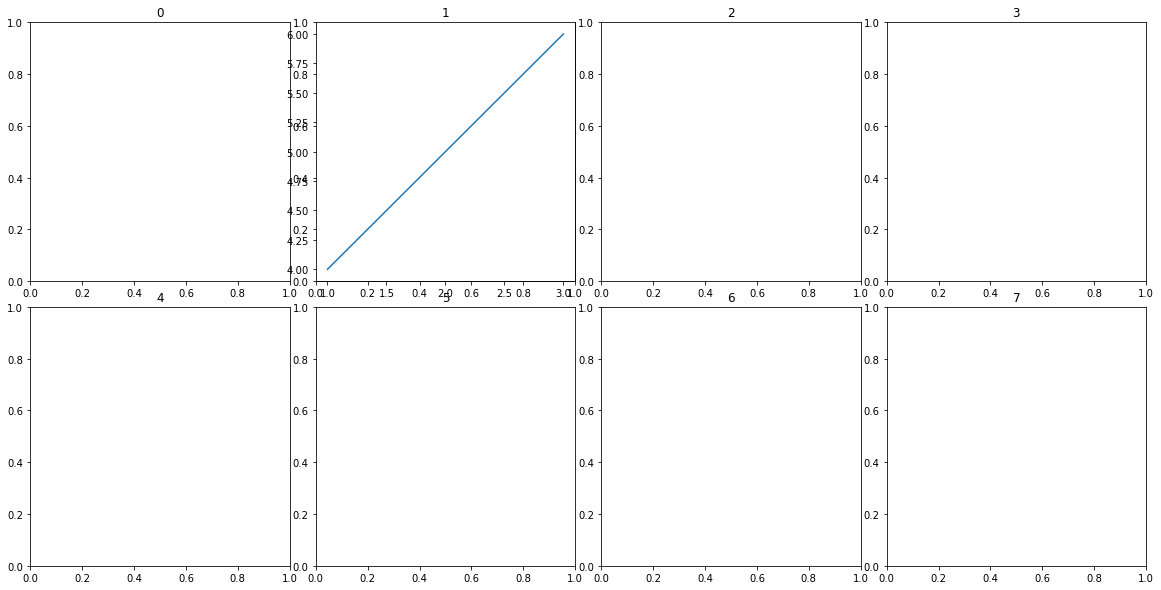

In [187]:
grid = plt.GridSpec(2, 4, hspace=0.1, wspace=0.1)
fig = plt.figure(figsize=(20, 10))
for i,a in enumerate(grid):
    ax = fig.add_subplot(grid[i])
    ax.set_title(i)
    
ax=fig.add_subplot(grid[0,1])
ax.plot([1,2,3], [4,5,6])

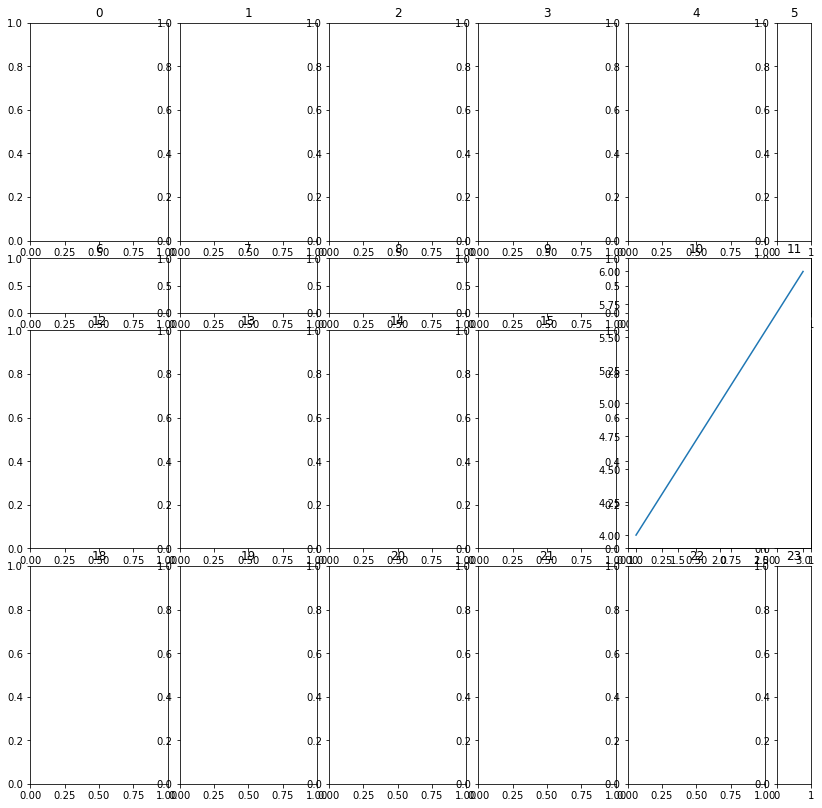

In [307]:
grid = plt.GridSpec(4, 6, hspace=0.1, wspace=0.1, 
                    width_ratios=[1,1,1,1,1,.25], height_ratios=[1,.25,1,1])  # make last column/2nd row skinny
fig = plt.figure(figsize=(14, 14))
for i,a in enumerate(grid):
    ax = fig.add_subplot(grid[i])
    ax.set_title(i)
    
ax=fig.add_subplot(grid[1:3,4:6])
ax.plot([1,2,3], [4,5,6])